In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, sum, concat_ws, count, desc

In [2]:
conf = SparkConf().setMaster('local[*]').setAppName("CarsData") \
.set("spark.driver.memory", "10g") \
.set("spark.executor.memory", "12g") \
.set("spark.driver.memoryOverhead", "512m") \
.set("spark.executor.memoryOverhead", "512m")

spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext


In [3]:
data = spark.read.options(header=True, 
                        escape='"', 
                        multiline=True,
                        #).csv('hdfs://localhost:9000/cars/used_cars_data.csv')
                        ).csv('hdfs://localhost:9000/user/mhhel/used_cars_data/used_cars_data.csv') #Mo's path

In [4]:
row_count = data.count()
column_count = len(data.columns)

print(f"Rows: {row_count}, Columns: {column_count}")

Rows: 3000040, Columns: 66


In [5]:
data.printSchema()

root
 |-- vin: string (nullable = true)
 |-- back_legroom: string (nullable = true)
 |-- bed: string (nullable = true)
 |-- bed_height: string (nullable = true)
 |-- bed_length: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- cabin: string (nullable = true)
 |-- city: string (nullable = true)
 |-- city_fuel_economy: string (nullable = true)
 |-- combine_fuel_economy: string (nullable = true)
 |-- daysonmarket: string (nullable = true)
 |-- dealer_zip: string (nullable = true)
 |-- description: string (nullable = true)
 |-- engine_cylinders: string (nullable = true)
 |-- engine_displacement: string (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- exterior_color: string (nullable = true)
 |-- fleet: string (nullable = true)
 |-- frame_damaged: string (nullable = true)
 |-- franchise_dealer: string (nullable = true)
 |-- franchise_make: string (nullable = true)
 |-- front_legroom: string (nullable = true)
 |-- fuel_tank_volume: string (nullable = tr

In [6]:
data.show(5)

+-----------------+------------+----+----------+----------+---------------+-----+--------+-----------------+--------------------+------------+----------+--------------------+----------------+-------------------+-----------+--------------+-----+-------------+----------------+--------------+-------------+----------------+---------+-------------+-------+--------------------+----------+--------------------+-----+------------+------+------+---------+--------+--------+-----------+-------------+----------+---------+--------------------+--------------------+----------+---------------+-------+---------------+-----------+------------------+-------+-------+--------------+-------------+------+-------------------+-----------+--------------------+------------+--------------------+------+------------+-----------------------+------------+--------------------+---------+-------+----+
|              vin|back_legroom| bed|bed_height|bed_length|      body_type|cabin|    city|city_fuel_economy|combine_fuel_

Based of our dataset we have decided that we want to discover and analyze the following:

* Discover/look into what kind of make_name & model_name is the most popular car listed in a certain city.
* Are certain types of cars more popular in the geographical sense of the US (say pick-up trucks in the southern part etc).
* Which 5 cities have most car listings

We decide to keep the following columns to work with based of what we think is relevant to our goals:

- city: City where the car is listed
- make_name: Make brand of the listed car
- model_name: Model of the listed car
- dealer_zip: Zipcode of the dealer
- engine_cylinder: Number and configuration of cylinders

In [7]:
columns_to_keep = ["city", "make_name", "model_name", "dealer_zip", "engine_cylinders"]

cleaned_data = data.select(*columns_to_keep)

Verify the new dataframe with it's columns:

In [8]:
cleaned_data.printSchema()
cleaned_data.show(5)

root
 |-- city: string (nullable = true)
 |-- make_name: string (nullable = true)
 |-- model_name: string (nullable = true)
 |-- dealer_zip: string (nullable = true)
 |-- engine_cylinders: string (nullable = true)

+--------+----------+---------------+----------+----------------+
|    city| make_name|     model_name|dealer_zip|engine_cylinders|
+--------+----------+---------------+----------+----------------+
| Bayamon|      Jeep|       Renegade|     00960|              I4|
|San Juan|Land Rover|Discovery Sport|     00922|              I4|
|Guaynabo|    Subaru|        WRX STI|     00969|              H4|
|San Juan|Land Rover|      Discovery|     00922|              V6|
|San Juan|Land Rover|Discovery Sport|     00922|              I4|
+--------+----------+---------------+----------+----------------+
only showing top 5 rows



In [9]:

import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum

def plot_null_values(df):
    """
    This function takes a PySpark DataFrame and plots the number of null values in each column.
    
    Args:
    df (pyspark.sql.DataFrame): The PySpark DataFrame to analyze.
    
    Returns:
    None: Displays a bar chart of null values per column.
    """
    
    # Step 1: Count the null values for each column
    null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
    
    # Step 2: Collect the results into a dictionary where key is the column name, and value is the null count
    null_counts_dict = null_counts.collect()[0].asDict()
    
    # Step 3: Prepare data for plotting
    columns = list(null_counts_dict.keys())
    null_values = [val / 3000040 for val in list(null_counts_dict.values())]
    
    # Step 4: Plot the data using Matplotlib
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.barh(columns, null_values, color='skyblue',height=0.6)  # Create a horizontal bar plot
    
    plt.xlabel('Number of Null Values (scaled by 1/3000040)', fontsize=12)  # X-axis label
    plt.ylabel('Columns', fontsize=12)  # Y-axis label
    plt.title('Number of Null Values Per Column', fontsize=14)  # Title of the plot
    
    # Annotate the bar plot with the null counts
    for i, val in enumerate(null_values):
        plt.text(val + 0.01, i, f'{val:.4f}', ha='left', va='center', fontsize=10)
    
    plt.tight_layout()  # Ensure the layout fits well
    plt.show()  # Display the plot



In [10]:
# plot_null_values(cleaned_data)

Now lets check for the the unique values of our features to see if there are any typos of any kind:

In [11]:
cleaned_data.select('make_name').distinct().collect()

[Row(make_name='Volkswagen'),
 Row(make_name='Sunbeam'),
 Row(make_name='Oldsmobile'),
 Row(make_name='Franklin'),
 Row(make_name='Koenigsegg'),
 Row(make_name='Pininfarina'),
 Row(make_name='Lexus'),
 Row(make_name='Jaguar'),
 Row(make_name='Saturn'),
 Row(make_name='Maserati'),
 Row(make_name='FIAT'),
 Row(make_name='Rover'),
 Row(make_name='Scion'),
 Row(make_name='Rolls-Royce'),
 Row(make_name='Mobility Ventures'),
 Row(make_name='Jeep'),
 Row(make_name='Mitsubishi'),
 Row(make_name='Kia'),
 Row(make_name='Chevrolet'),
 Row(make_name='RAM'),
 Row(make_name='Volvo'),
 Row(make_name='Saleen'),
 Row(make_name='Bricklin'),
 Row(make_name='Hyundai'),
 Row(make_name='Saab'),
 Row(make_name='Hudson'),
 Row(make_name='Honda'),
 Row(make_name='INFINITI'),
 Row(make_name='MINI'),
 Row(make_name='Karma'),
 Row(make_name='Audi'),
 Row(make_name='Lamborghini'),
 Row(make_name='Austin'),
 Row(make_name='SRT'),
 Row(make_name='Cadillac'),
 Row(make_name='Isuzu'),
 Row(make_name='Plymouth'),
 Row(

In [12]:
cleaned_data.select('model_name').distinct().collect()

[Row(model_name='MDX'),
 Row(model_name='RS 7'),
 Row(model_name='F-600 Super Duty'),
 Row(model_name='Silver Cloud'),
 Row(model_name='Cirrus'),
 Row(model_name='Trooper II'),
 Row(model_name='GLE-Class'),
 Row(model_name='California T'),
 Row(model_name='Impreza WRX STI'),
 Row(model_name='944'),
 Row(model_name='Astra'),
 Row(model_name='Corona'),
 Row(model_name='F8 Tributo'),
 Row(model_name='250 GTO'),
 Row(model_name='Outlook'),
 Row(model_name='RAM Van'),
 Row(model_name='F12tdf'),
 Row(model_name='Villager'),
 Row(model_name='Contour'),
 Row(model_name='3200'),
 Row(model_name='S60'),
 Row(model_name='TC'),
 Row(model_name='Savoy'),
 Row(model_name='Hawk'),
 Row(model_name='1500'),
 Row(model_name='Highlander Hybrid'),
 Row(model_name='Shadow'),
 Row(model_name='Road Runner'),
 Row(model_name='XLR-V'),
 Row(model_name='Q7'),
 Row(model_name='Captiva Sport'),
 Row(model_name='Mark VII'),
 Row(model_name='DBS'),
 Row(model_name='Kadett'),
 Row(model_name='740'),
 Row(model_name=

In [13]:
cleaned_data.select('city').distinct().collect()

[Row(city='Rhinebeck'),
 Row(city='Worcester'),
 Row(city='Hanover'),
 Row(city='Agawam'),
 Row(city='Prattville'),
 Row(city='Center Rutland'),
 Row(city='Tyler'),
 Row(city='Saint George'),
 Row(city='Belle Plaine'),
 Row(city='Bluffton'),
 Row(city='Fredonia'),
 Row(city='West Sand Lake'),
 Row(city='Harleysville'),
 Row(city='Grimes'),
 Row(city='Hanceville'),
 Row(city='Minster'),
 Row(city='Aitkin'),
 Row(city='Sugar City'),
 Row(city='Santa Paula'),
 Row(city='Springfield'),
 Row(city='Oakhurst'),
 Row(city='Bow'),
 Row(city='Tempe'),
 Row(city='Corona'),
 Row(city='Pleasant View'),
 Row(city='Edmonds'),
 Row(city='Bowling Green'),
 Row(city='Charleston'),
 Row(city='Harrisburg'),
 Row(city='Woods Cross'),
 Row(city='Frontenac'),
 Row(city='North Manchester'),
 Row(city='North Charleroi'),
 Row(city='Church Hill'),
 Row(city='Tumwater'),
 Row(city='Pasco'),
 Row(city='Lawrenceville'),
 Row(city='Auburn'),
 Row(city='Wellington'),
 Row(city='Upper Saddle River'),
 Row(city='Batav

In [14]:
cleaned_data.select('dealer_zip').distinct().collect()

[Row(dealer_zip='11563'),
 Row(dealer_zip='08648'),
 Row(dealer_zip='02090'),
 Row(dealer_zip='11722'),
 Row(dealer_zip='36526'),
 Row(dealer_zip='02053'),
 Row(dealer_zip='37311'),
 Row(dealer_zip='18509'),
 Row(dealer_zip='28117'),
 Row(dealer_zip='61354'),
 Row(dealer_zip='55445'),
 Row(dealer_zip='43085'),
 Row(dealer_zip='85022'),
 Row(dealer_zip='47960'),
 Row(dealer_zip='29210'),
 Row(dealer_zip='18947'),
 Row(dealer_zip='77339'),
 Row(dealer_zip='97128'),
 Row(dealer_zip='66762'),
 Row(dealer_zip='75007'),
 Row(dealer_zip='60053'),
 Row(dealer_zip='35004'),
 Row(dealer_zip='49079'),
 Row(dealer_zip='32773'),
 Row(dealer_zip='06518'),
 Row(dealer_zip='16504'),
 Row(dealer_zip='19132'),
 Row(dealer_zip='19095'),
 Row(dealer_zip='24504'),
 Row(dealer_zip='28334'),
 Row(dealer_zip='28675'),
 Row(dealer_zip='37774'),
 Row(dealer_zip='49307'),
 Row(dealer_zip='36067'),
 Row(dealer_zip='32812'),
 Row(dealer_zip='55321'),
 Row(dealer_zip='39350'),
 Row(dealer_zip='72472'),
 Row(dealer_

FYI about the datatypes of the columns, we want to keep **dealer_zip** as a string because it preserves the leading zeros in the zip code, which good to have as the first number usually represents a broad region in the US.

# Analysis

## Most sold car in Houston

In [15]:
# Filter for records in Houston and create a "Make + Model" column
houston_sales = cleaned_data.filter(col("city") == "Houston")
houston_sales = houston_sales.withColumn("Make_Model", concat_ws(" ", col("make_name"), col("model_name")))

# Count the occurrences of each "Make + Model" and sort to find the most sold
most_sold_houston = houston_sales.groupBy("Make_Model").agg(count("*").alias("count")) \
                                  .orderBy(desc("count")) \
                                  .limit(1)

# Show the result
most_sold_houston.show()

+----------+-----+
|Make_Model|count|
+----------+-----+
|Ford F-150| 1778|
+----------+-----+



## Cities with most sales

In [16]:
# Group by city and count the number of occurrences
city_sales_count = cleaned_data.groupBy("city").agg(count("*").alias("sales_count"))

# Order by the count in descending order and limit to top 5
top_5_cities = city_sales_count.orderBy(desc("sales_count")).limit(5)

# Show the result
top_5_cities.show()

+------------+-----------+
|        city|sales_count|
+------------+-----------+
|     Houston|      43777|
| San Antonio|      24947|
|    Columbus|      18333|
|       Miami|      18198|
|Jacksonville|      16837|
+------------+-----------+



### Bar Chart

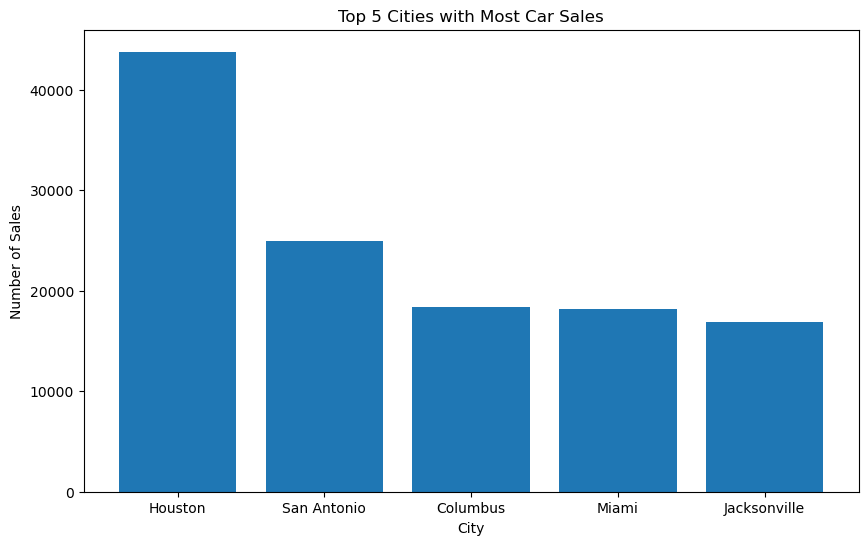

In [19]:
# Collect the results from the existing top_5_cities DataFrame
top_5_cities_data = top_5_cities.collect()

# Prepare data for plotting
cities = [row["city"] for row in top_5_cities_data]
sales_counts = [row["sales_count"] for row in top_5_cities_data]

# Plot the plot to make it a plotted plot and become the plotted plot plotter

plt.figure(figsize=(10, 6))
plt.bar(cities, sales_counts)
plt.xlabel("City")
plt.ylabel("Number of Sales")
plt.title("Top 5 Cities with Most Car Sales")
plt.show()

## Most common engine type

In [17]:
# Group by engine_cylinders and count the number of occurrences
cylinder_count = cleaned_data.groupBy("engine_cylinders").agg(count("*").alias("count"))

# Order by the count in descending order and limit to top 5
top_5_cylinders = cylinder_count.orderBy(desc("count")).limit(5)

# Show the result
top_5_cylinders.show()

+--------------------+-------+
|    engine_cylinders|  count|
+--------------------+-------+
|                  I4|1418291|
|                  V6| 737066|
|                  V8| 279939|
|                NULL| 100581|
|V8 Flex Fuel Vehicle|  78372|
+--------------------+-------+



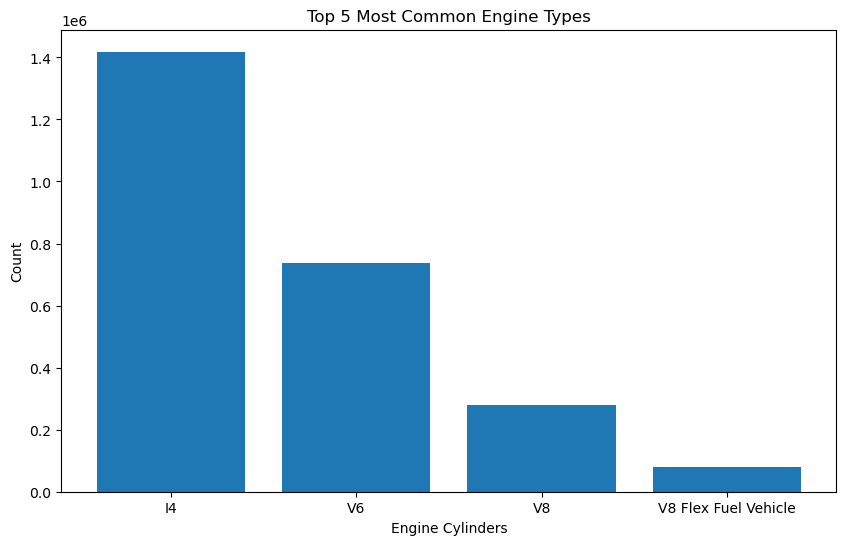

In [21]:
# Collect the results from the existing top_5_cylinders DataFrame
top_5_cylinders = top_5_cylinders.filter(col("engine_cylinders").isNotNull())
top_5_cylinders_data = top_5_cylinders.collect()

# Prepare data for plotting
engine_types = [row["engine_cylinders"] for row in top_5_cylinders_data]
engine_counts = [row["count"] for row in top_5_cylinders_data]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(engine_types, engine_counts)
plt.xlabel("Engine Cylinders")
plt.ylabel("Count")
plt.title("Top 5 Most Common Engine Types")
plt.show()
